### Bibliotecas

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

### Implementação dos Modelos Lineares de Aprendizagem de Máquina

In [270]:
class PerceptronLA:
    def __init__(self, _X, _Y, tmax = 10000):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.tmax = tmax
    
    def fit(self):

        W = np.zeros(self.X.shape[1])
        self.W = np.copy(W)
        indice_class_incorretas = np.arange(len(self.X))
        self.min_erros = len(indice_class_incorretas)

        for i in range(self.tmax):
            indice_aleatorio = np.random.choice(indice_class_incorretas)

            W = W + (self.Y[indice_aleatorio] * self.X[indice_aleatorio])

            qtd_erros = 0
            lista_provisoria = []

            for j in range(len(self.X)):
                classificacao_atual = np.sign(W @ self.X[j])

                if classificacao_atual != self.Y[j]:
                    qtd_erros += 1
                    lista_provisoria.append(j)
            
            indice_class_incorretas = np.array(lista_provisoria)

            if qtd_erros == 0:
                self.W = np.copy(W)
                self.min_erros = qtd_erros
                break

            if qtd_erros < self.min_erros:
                self.W = np.copy(W)
                self.min_erros = qtd_erros
    
    def predict(self, _X):
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)
    
    def predict_digit(self):
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

In [271]:
class RegressaoLinear:
    def __init__(self, _X, _Y):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
    
    def fit(self):

        matriz_XtX = self.X.T @ self.X
        inversa_matriz_XtX = np.linalg.inv(matriz_XtX)
        matriz_XtY = self.X.T @ self.Y
        
        self.W = inversa_matriz_XtX @ matriz_XtY
    
    def predict(self, _X):
        
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.PREDICT = []

        for x in X:
            self.PREDICT.append(np.sign(self.W @ x))

        self.PREDICT = np.array(self.PREDICT)
    
    def predict_digit(self):
        
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

In [272]:
class RegressaoLogistica:
    def __init__(self, _X, _Y, eta = 0.1, tmax = 1000, bs=1000000, lambda_regula = 0.0):
        self.X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.Y = _Y
        self.eta = eta
        self.tmax = tmax
        self.batch_size = bs
        self.lambda_regula = lambda_regula

    def fit(self):

        self.W = np.zeros(self.X.shape[1])

        for t in range(self.tmax):
            
            somatorio = np.zeros(self.X.shape[1])

            if self.batch_size < self.X.shape[0]:
                idx = np.random.choice(len(self.X), size=self.batch_size, replace=False)
                Xb = self.X[idx]
                Yb = self.Y[idx]
            else:
                Xb = self.X
                Yb = self.Y

            for i in range(Xb.shape[0]):
                exponencial = np.exp(Yb[i]*(self.W @ Xb[i]))
                somatorio += (Yb[i]*Xb[i]) / (1 + exponencial)
            
            gradiente = -(1/Xb.shape[0]) * somatorio
            gradiente += (2 * self.lambda_regula / self.X.shape[0]) * self.W

            if np.linalg.norm(gradiente) < 0.00000000000001 :
                break

            self.W = self.W - (self.eta * gradiente)

    def predict_prob(self, _X):
        
        self.PROB = []

        for x in _X:
            z = x @ self.W
            self.PROB.append(1 / (1 + np.exp(-z)))
            
        self.PROB = np.array(self.PROB)

    def predict(self, _X):
        
        X = np.hstack((np.ones((_X.shape[0], 1)), _X))
        self.predict_prob(X)
        self.PREDICT = np.empty(len(self.PROB), dtype = int)

        for i in range(len(self.PROB)):
            if self.PROB[i] >= 0.5:
                self.PREDICT[i] = 1
            else:
                self.PREDICT[i] = -1
    
    def predict_digit(self):
        
        self.DPREDICT = np.where(self.PREDICT == -1, 5, self.PREDICT)

### Implementação Weight Decay

In [273]:
def erro_binario(y_real, y_pred):
    return np.mean(np.array(y_real) != np.array(y_pred))

In [274]:
def weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta=0.1, tmax=1000, bs = 1000000):
    modelos = []
    erros_val = []

    for lam in lambdas:
        modelo = RegressaoLogistica(X_treino, Y_treino, eta=eta, tmax=tmax, bs=bs, lambda_regula=lam)
        modelo.fit()
        
        modelo.predict(X_val)
        erro = erro_binario(Y_val, modelo.PREDICT)
        
        modelos.append(modelo)
        erros_val.append(erro)
        
        print(f"Lambda = {lam:<10} | Erro validação = {erro:.4f}")
    
    return modelos, erros_val

In [275]:
def weight_decay_completo(X_treino, Y_treino, X_val, Y_val, X_teste, Y_teste, lambdas, eta=0.1, tmax=1000, bs = 1000000):
    
    _, erros_val = weight_decay_selecao(X_treino, Y_treino, X_val, Y_val, lambdas, eta, tmax, bs)
    
    menor_erro = erros_val[0]
    melhor_idx = 0
    for i in range(1, len(erros_val)):
        if erros_val[i] < menor_erro:
            menor_erro = erros_val[i]
            melhor_idx = i
    
    melhor_lambda = lambdas[melhor_idx]
    
    X_treino_final = np.vstack((X_treino, X_val))
    Y_treino_final = np.concatenate((Y_treino, Y_val))
    
    modelo_final = RegressaoLogistica(X_treino_final, Y_treino_final, eta=eta, tmax=tmax, lambda_regula=melhor_lambda)
    modelo_final.fit()
    
    return melhor_lambda

### Classificação dos Dígitos 1x5

Separando train_redu em treino (80%) e validação (20%) antes de filtrar. Depois filtrando os dígitos 1 e 5 em cada conjunto (treino, validação e teste)

In [276]:
train_redu = pd.read_csv("DatasetProjeto1/train_redu.csv")
test_redu = pd.read_csv("DatasetProjeto1/test_redu.csv")

train_redu_misturado = train_redu.sample(frac=1, random_state=42).reset_index(drop=True)

tamanho_treino = int(0.8 * len(train_redu_misturado))

train_wd = train_redu_misturado.iloc[:tamanho_treino]
val_wd = train_redu_misturado.iloc[tamanho_treino:]

train1x5 = train_wd[train_wd["label"].isin([1,5])].copy()
val1x5 = val_wd[val_wd["label"].isin([1,5])].copy()
test1x5 = test_redu[test_redu["label"].isin([1,5])].copy()

Realizando o teste de Shapiro Wilk (fazendo uso da biblioteca Scipy) para verificar se o conjunto de dados segue ou se aproxima de uma distribuição normal

In [277]:
stat, p = stats.shapiro(train1x5)

print("Estatística:", stat)
print("p-valor:", p)

if p > 0.05:
    print("Conclusão: A distribuição segue ou se aproxima de uma normal")
else:
    print("Conclusão: A distribuição não segue ou se aproxima de uma normal")

Estatística: 0.8917367501554899
p-valor: 1.2690237965495312e-40
Conclusão: A distribuição não segue ou se aproxima de uma normal


Como os dados não seguem uma distribuição normal, aplicamos a Normalização Min/Max, ideal para conjunto de dados que não seguem uma distribuição Gaussiana

In [278]:
scaler = MinMaxScaler()

train1x5[["intensidade", "simetria"]] = scaler.fit_transform(train1x5[["intensidade", "simetria"]])
val1x5[["intensidade", "simetria"]] = scaler.transform(val1x5[["intensidade", "simetria"]])
test1x5[["intensidade", "simetria"]] = scaler.transform(test1x5[["intensidade", "simetria"]])

Plotando os dados de treino

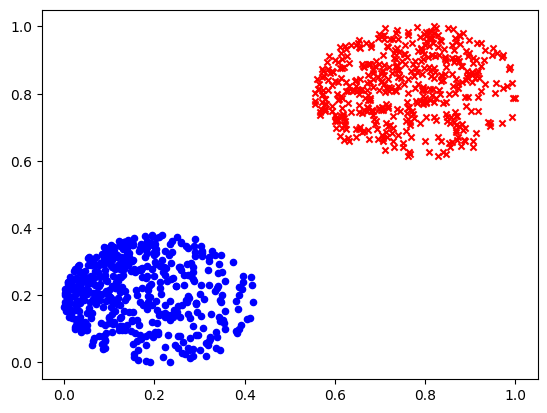

In [279]:
label1 = train1x5[train1x5["label"] == 1]
label5 = train1x5[train1x5["label"] == 5]

plt.scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
plt.scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

Construindo os vetores X e Y (treino, validação e teste) com +1 para label = 1 e -1 para label = 5

In [280]:
X_treino = train1x5[["intensidade", "simetria"]].to_numpy()
Y_treino = train1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_val = val1x5[["intensidade", "simetria"]].to_numpy()
Y_val = val1x5["label"].map({1: 1, 5: -1}).to_numpy()

X_teste = test1x5[["intensidade", "simetria"]].to_numpy()
Y_teste = test1x5["label"].map({1: 1, 5: -1}).to_numpy()

Aplicando a Heurística Weight Decay para a Regressão Logística 

In [281]:
lambdas = [10**k for k in range(-4, 4)]
melhor_lambda = weight_decay_completo(X_treino, Y_treino, X_val, Y_val, X_teste, Y_teste, lambdas, 0.1, 1000, 32)
print(f"Lambda escolhido: {melhor_lambda}")

Lambda = 0.0001     | Erro validação = 0.0000
Lambda = 0.001      | Erro validação = 0.0000
Lambda = 0.01       | Erro validação = 0.0000
Lambda = 0.1        | Erro validação = 0.0000
Lambda = 1          | Erro validação = 0.0000
Lambda = 10         | Erro validação = 0.0000
Lambda = 100        | Erro validação = 0.0927
Lambda = 1000       | Erro validação = 0.3145
Lambda escolhido: 0.0001


Treinando os três classificadores com os dados de train1x5

In [282]:
PLAclass = PerceptronLA(X_treino, Y_treino)
RLclass = RegressaoLinear(X_treino, Y_treino)
RLOclass = RegressaoLogistica(X_treino, Y_treino, 0.1, 1000, 32, melhor_lambda)

PLAclass.fit()
RLclass.fit()
RLOclass.fit()

Testando os três classificadores com os dados de test1x5

In [283]:
PLAclass.predict(X_teste)
RLclass.predict(X_teste)
RLOclass.predict(X_teste)

Plotando as retas de cada classificador sobre os dados de teste

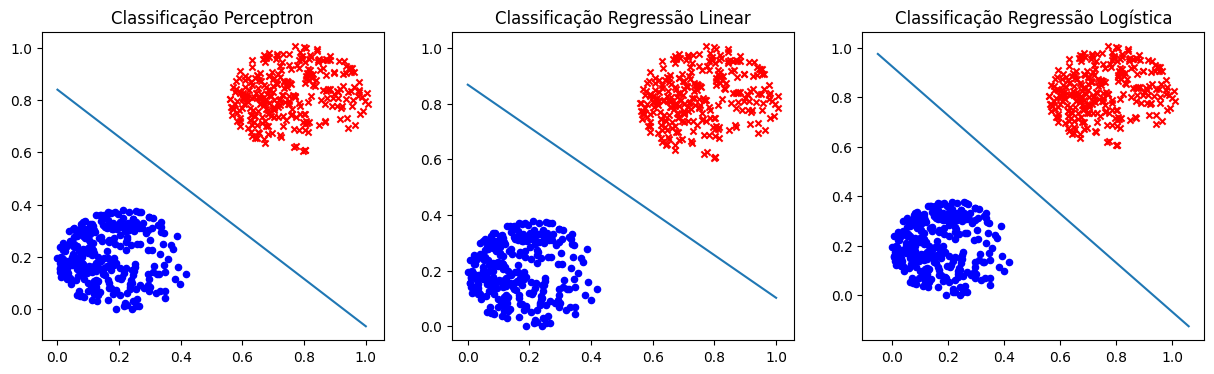

In [284]:
label1 = test1x5[test1x5["label"] == 1]
label5 = test1x5[test1x5["label"] == 5]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Gráfico do Perceptron

ax[0].scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
ax[0].scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

b  = PLAclass.W[0]
w1 = PLAclass.W[1]
w2 = PLAclass.W[2]

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)
y = -(w1/w2)*x - (b/w2)

ax[0].plot(x, y)
ax[0].set_title("Classificação Perceptron")

# Gráfico da Regressão Linear

ax[1].scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
ax[1].scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

b  = RLclass.W[0]
w1 = RLclass.W[1]
w2 = RLclass.W[2]

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)
y = -(w1/w2)*x - (b/w2)

ax[1].plot(x, y)
ax[1].set_title("Classificação Regressão Linear")

# Gráfico da Regressão Logística

ax[2].scatter(label1["intensidade"], label1["simetria"], color='blue', marker='o', s=20)
ax[2].scatter(label5["intensidade"], label5["simetria"], color='red', marker='x', s=20)

b  = RLOclass.W[0]
w1 = RLOclass.W[1]
w2 = RLOclass.W[2]

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 200)
y = -(w1/w2)*x - (b/w2)

ax[2].plot(x, y)
ax[2].set_title("Classificação Regressão Logística")

plt.show()

Matriz de Confusão e Relatórios de Eficácia de Classificação